In [1]:
import os 

import numba
import math

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import erlang

In [2]:
def get_linear_burst(t,tlim,a):
    if t<tlim:
        return 1.0
    elif t>=tlim:
        return a*t

In [3]:
def taul_to_minutes(t,n,k):
    return t*(float(k)/float(n))*23.0
    

In [4]:
def minutes_to_taul(t,n,k):
    return t*(float(n)/float(k))/23.0

In [5]:
def erlang_pdf(t,mu,k):
    # number of diferent exponential events that are taking place
    # scale parameter
    
    return mu*((mu*t)**(k-1))*np.exp(-mu*t)/math.factorial(k-1)

In [76]:
@numba.jit    
def system_evolution(delta_t,Nb0,B,Np0,alpha,N,k,nd,nu,niter):
    
    # Volume of the system
    V = float(Nb0)/float(B)
    
    # Initialization of vectors that contain information about bacteria
    states = np.zeros(Nb0,dtype=np.int8)
    infection_time = np.zeros(Nb0, dtype=np.float16)
    #sizes = mmax*np.random.uniform(size=Nb0)
    sizes = np.zeros(Nb0)
    Nt = np.zeros(Nb0, dtype=np.int8)
    
    # Initialization of vectors that grow with time steps
    time = []
    phages = []
    bacteria = []
    
    #We store the first values of the concentratioin of bacteria and phage
    bacteria.append(float(Nb0)/float(V))
    phages.append(float(Np0)/float(V))
    
    # We initialize time
    t = 0.0
    time.append(t)
    
    # We initialize the number of phages
    Np = Np0
    
    # probability of new timer molecules for infected bacteria
    prob_new_timer = k*delta_t
    prob_growth = alpha*delta_t
    
    iteration = 0
    
    for n in range(0,niter):
        
        # we count the infected and uninfected bacteria
        n_infected = len(np.where(states==1)[0])
        n_uninfected = len(np.where(states==0)[0])
        Nb = n_infected + n_uninfected
        
        # Probability of infection at this time step
        prob_infection = (nu*delta_t*(float(Np)/V))
        prob_superinfection = (nu*delta_t*(float(Np)/V))
        sum_probs = prob_superinfection + prob_new_timer
        
        # We iterate over the already infected cells
        for i in np.where(states==1)[0]:
            r = np.random.uniform()
            if r < prob_new_timer:
                Nt[i] = Nt[i] + 1
                #print('New timer')
                if Nt[i] >= N:
                    tau = t - infection_time[i]
                    Np = Np + int(get_linear_burst(tau,15.0,1.0))
                    states[i] = 2
                    
                    # We delete the dead cells from all the variables dependent on the number of bacteria
                    np.delete(states,i)
                    np.delete(infection_time,i)
                    np.delete(sizes,i)
                    np.delete(Nt,i)
                   
            elif prob_new_timer < r < sum_probs:
                if Np > 0:
                    Np = Np - 1
                else:
                    Np = 0
                    
                if Nt[i] < nd:
                    Nt[i] = 0 
                elif Nt[i] >= nd:
                    Nt[i] = Nt[i] - nd
            
        
        # We iterate over the non infected cells to see if they get infected
        non_infected_indices = np.where(states==0)[0]
        sumprobs = prob_infection + alpha*delta_t
        for i in non_infected_indices:
            r = np.random.uniform()
            if r<prob_infection:
                #print('first infection')
                # They are infected now
                states[i] = 1
                Np = Np-1
                # Wr store their infection time
                infection_time[i] = t
            elif prob_infection<r<sumprobs:
                # The cell that has divided has a new size
                sizes[i] = 0.0
                    
                # We re-initialize all vectors that depend on Nb
                sizes = np.append(sizes,0.0)
                states = np.append(states,0)
                infection_time = np.append(infection_time,0.0)
                Nt = np.append(Nt,0)
                    
        Nb = len(np.where(states==0)[0]) + len(np.where(states==1)[0])
        
        t = t + delta_t
        phages.append(float(Np)/V)
        time.append(t)
        bacteria.append(float(len(np.where(states==0)[0]) + len(np.where(states==1)[0]))/V)

        
        iteration = iteration + 1
        if np.mod(iteration,1000)==0.0:
            print(Nb)
    
    
    return time,phages,bacteria

In [81]:
# The time units are (n/k) which is tau_l
delta_t = 0.01
Nb0 = 50
B = 2.0e7
Np0 = 0
N = 60
k = 6.0
nd = 30
nu = 5.0e-9

# The doubling time in minutes
doubling_time = 20.0
alpha = 1.0/minutes_to_taul(doubling_time,N,k)

niter = 3000

In [82]:
time_vector,nphages,nbacteria = system_evolution(delta_t, Nb0, B,Np0, alpha, N, k, nd, nu, niter)


152
490
1506


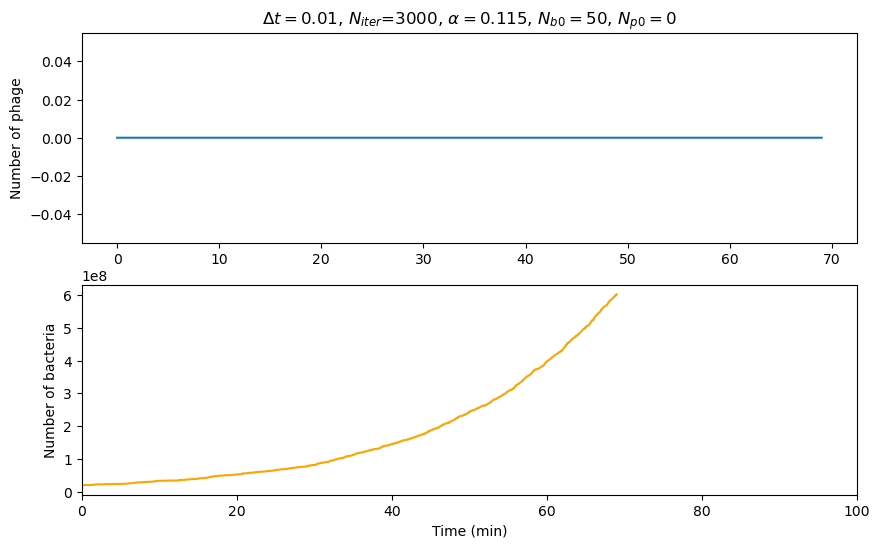

In [83]:
save_plot = False

# We change the time vector to minutes
time_mins = [taul_to_minutes(t,N,k) for t in time_vector]

fig, ax = plt.subplots(2,1,figsize=(10,6))

ax[0].plot(time_mins,nphages,label='Phage')
ax[0].set_title(r'$\Delta t=$' + str(delta_t) + ', ' + r'${N}_{iter}$=' + str(niter)
          +', ' + r'$\alpha=$' + str(alpha)+ ', ' + r'${N}_{b0}=$' +str(Nb0)+
          ', ' + r'${N}_{p0}=$' + str(Np0))
ax[0].set_ylabel('Number of phage')

ax[1].plot(time_mins,nbacteria,label='Bacteria',color='orange')

ax[1].set_xlabel('Time (min)')
ax[1].set_ylabel('Number of bacteria')

ax[1].set_xlim(0.0,100.0)


if save_plot == True:
    figure_path = os.path.join(os.getcwd(),'FIGURES','First figures')
    figure_name = str(delta_t)+'_'+str(niter)+'_'+str(Nb0)+'_'+str(Np0)+'.png'
    fig.savefig(os.path.join(figure_path,figure_name))

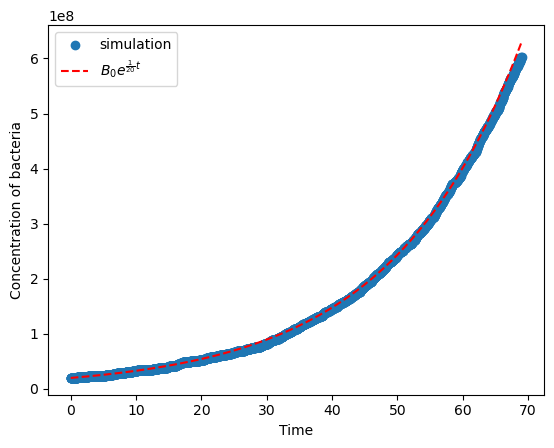

In [84]:
# We plot the concentration of bacteria as a function of time 
# and also the exponential equation it should follow
save_plot=False

exponential = [2.0e7*np.exp((1.0/20.0)*i) for i in time_mins]


fig, ax = plt.subplots()
ax.scatter(time_mins,nbacteria,label='simulation')
ax.plot(time_mins,exponential,linestyle='dashed',color='red',label=r'${B}_{0}{e}^{\frac{1}{20} t}$')
ax.set_xlabel('Time')
ax.set_ylabel('Concentration of bacteria')
ax.legend(loc='best')

if save_plot==True:
    figure_path = os.path.join(os.getcwd(),'FIGURES','First figures')
    figure_name = 'cell_growth_0.83.png'
    fig.savefig(os.path.join(figure_path,figure_name))